**Read Incoming Data Utility (One Vessel)**

Use this notebook to read in incoming data from GNSS and make random depths and place into a seafloor model file for one vessel only. 

In the cell below please enter the required parameters and data filenames.

In [1]:
# Incoming serial connection
gnss_port = 'COM5'
gnss_baud = 115200

# Input seafloor model file names
vesselA_model_file = 'output/vA_model3.nc'

# Output seafloor model file names
vesselA_output_file = 'output/vA_model_filled2.nc'

Import Libraries

In [2]:
from datetime import datetime as dt
import serial
import pynmea2
import xarray as xr
import csv
import random
import geopandas
from shapely.geometry import Point, box
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely.ops import transform
import pandas as pd
from shapely.geometry import Polygon
import numpy as np
from shapely.prepared import prep
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import math

Import the vessel model files into xarrays and pull out relavent metadata

In [3]:
# Open the data models for each vessel
vA = xr.open_dataset(vesselA_model_file)

# Pull out attributes for survey as a whole and for each vessel for easy use
home_point = vA.attrs['home_point']
away_point = vA.attrs['away_point']
allow_sigmaVert = vA.attrs['allowable_sigmaVertical']
input_geodetics = 'EPSG:4326'                                ###### Put in attributes
project_geodetics = 'EPSG:32619' 

vA_sigmaVert = vA.attrs['vesselA_sigmaVertical']
vA_sigmaHor = vA.vA_hypo1.attrs['vesselA_sigmaHorizontal']
vA_min_safe_depth = vA.vA_hypo1.attrs['vesselA_min_safe_depth']

vB_sigmaVert = vB.vB_hypo1.attrs['vesselB_sigmaVertical']
vB_sigmaHor = vB.vB_hypo1.attrs['vesselB_sigmaHorizontal']
vB_min_safe_depth = vB.vB_hypo1.attrs['vesselB_min_safe_depth']

"\nvA_sigmaVert = vA.vA_hypo1.attrs['sigmaVertical']\nvA_sigmaHor = vA.vA_hypo1.attrs['sigmaHorizontal']\nvA_min_safe_depth = vA.vA_hypo1.attrs['min_safe_depth']\n\nvB_sigmaVert = vB.vB_hypo1.attrs['sigmaVertical']\nvB_sigmaHor = vB.vB_hypo1.attrs['sigmaHorizontal']\nvB_min_safe_depth = vB.vB_hypo1.attrs['min_safe_depth']\n"

Initialize functions for calculating running variance and initialize the geodetic transform.

In [4]:
# For a new value new_value, compute the new count, new mean, the new M2.
# mean accumulates the mean of the entire dataset
# M2 aggregates the squared distance from the mean
# count aggregates the number of samples seen so far
def update(existing_aggregate, new_value):
    (count, mean, M2) = existing_aggregate
    count += 1
    delta = new_value - mean
    mean += delta / count
    delta2 = new_value - mean
    M2 += delta * delta2
    return (count, mean, M2)

# Retrieve the mean, variance and sample variance from an aggregate
def finalize(existing_aggregate):
    (count, mean, M2) = existing_aggregate
    if count < 2:
        return float("nan")
    else:
        (mean, variance, sample_variance) = (mean, M2 / count, M2 / (count - 1))
        return (mean, variance, sample_variance)
    
wgs84 = pyproj.CRS(input_geodetics)
utm = pyproj.CRS(project_geodetics)

projection = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform

Initialize a function for reading the data in for the vessels.

In [5]:
def read_incoming_data(vessel_output_file, vDS, vessel, home, away, projection, gnss_port, gnss_baud):
    ser = serial.Serial(port=gnss_port, baudrate=gnss_baud)
    
    count = 0
    depth = 2.5
    
    while count < 1000:
        try:
            line_raw = ser.readline()
            line = bytes.decode(line_raw)
            
            try:
                msg = pynmea2.parse(line)
            except:
                pass
                
            if msg.sentence_type == 'RMC':
                lat = msg.latitude
                long = msg.longitude
                
                coords = transform(projection, Point([long, lat]))
                north = coords.y
                east = coords.x
                
                north = round(north - home[1])
                east = round(east - home[0])
                
                depth = random.uniform(depth + 0.11, depth - 0.1)
                
                if np.isnan(vDS['soundings'].loc[dict(north=north, east=east, vessel=vessel)]):
                    vDS['depth'].loc[dict(north=north, east=east, vessel=vessel)] = depth
                    vDS['soundings'].loc[dict(north=north, east=east, vessel=vessel)] = 1
                    vDS['M2'].loc[dict(north=north, east=east, vessel=vessel)] = 0
                    vDS['stdev'].loc[dict(north=north, east=east, vessel=vessel)] = 0
                    
                    print(depth)

                else:
                    prev_soundings = vDS['soundings'].loc[dict(north=north, east=east, vessel=vessel)]
                    prev_depth = vDS['depth'].loc[dict(north=north, east=east, vessel=vessel)]
                    prev_M2 = vDS['M2'].loc[dict(north=north, east=east, vessel=vessel)]

                    updates = update((prev_soundings, prev_depth, prev_M2), depth)
                    finals = finalize(updates)

                    vDS['depth'].loc[dict(north=north, east=east, vessel=vessel)] = updates[1]
                    vDS['soundings'].loc[dict(north=north, east=east, vessel=vessel)] = updates[0]
                    vDS['M2'].loc[dict(north=north, east=east, vessel=vessel)] = updates[2]
                    vDS['stdev'].loc[dict(north=north, east=east, vessel=vessel)] = math.sqrt(finals[1])
                    
                    print(north, east, depth)
                
                interval = count / 10
                
                if interval.is_integer():
                    vA.to_netcdf(path=vesselA_output_file)
                    print('save')
                count += 1
        except:
            pass
    
    ser.close()
    return vDS

In [6]:
vA = read_incoming_data(vesselA_output_file, vA, 'A', home_point, away_point, projection, gnss_port, gnss_baud)

2.602395951692225
save
43 65 2.5324891448120925
43 65 2.626925352898118
43 65 2.7031299370588733
43 65 2.6189036568423636
43 65 2.6072568890832954
43 65 2.590069708239457
43 65 2.6660476557322235
43 65 2.5676619823063924
43 65 2.6634069431884013
43 65 2.7477612514138823
save
43 65 2.8155741871470736
43 65 2.776226673224763
43 65 2.7009382052614117
43 65 2.782391919628594
43 65 2.7692927411200414
43 65 2.738339880997285
43 65 2.640489218668879
43 65 2.692335846110654
43 65 2.658427690510771
43 65 2.7127250597894075
save
2.7802477985783165
43 78 2.6965356822330184
43 78 2.8035767442208464
43 78 2.774085380583694
43 78 2.8283448405825466
43 78 2.7313641734520693
43 78 2.6764405597808913
43 78 2.669633323336522
43 78 2.65885684876562
43 78 2.7016559339006365
save
43 78 2.723923671389186
43 78 2.7100907814679314
2.7645311723409662
62 78 2.728195423186233
62 78 2.6618568796121873
62 78 2.7604970181827975
62 78 2.726722739839606
62 78 2.820882487077699
62 78 2.7774821202800912
62 78 2.7459509

99 89 3.5934255246523863
99 89 3.5806639974651957
99 89 3.6360517962491463
save
99 89 3.6884938544630987
99 89 3.6071631232050585
99 89 3.6527581112217593
99 89 3.646408064832576
99 89 3.632291921216673
99 89 3.634390804289058
99 89 3.6781080030705566
99 89 3.776673307783595
99 89 3.7647921237633577
99 89 3.7009146069444605
save
99 89 3.648016156215527
99 89 3.5819765095458806
99 89 3.5489463625613626
99 89 3.479220116148335
99 89 3.393022464863856
99 89 3.501836742267266
99 89 3.4279130615777524
99 89 3.328705723161183
99 89 3.374814528694885
99 89 3.474968814809941
save
99 89 3.531271210323829
99 89 3.4741976245379553
99 89 3.385501539955533
99 89 3.4351389695421517
99 89 3.539756656998045
99 89 3.525546381854842
99 89 3.5460174591278086
99 89 3.578685302461908
99 89 3.661055989529035
99 89 3.721732061939565
save
99 89 3.8143965316528425
3.9098053603487837
100 102 3.918980967221671
100 102 3.895608102612864
100 102 3.8512592001604706
100 102 3.9285175437771787
100 102 4.0034821483824

61 52 6.337033287219118
61 52 6.328752719139418
61 52 6.239629721578665
61 52 6.306036750950884
61 52 6.301137854656852
61 52 6.2350721004930545
61 52 6.2417568154627
61 52 6.218561771464672
61 52 6.196378260263556
save
61 52 6.1697319363035135
61 52 6.228796296534858
61 52 6.186857373617952
61 52 6.270805107095344
61 52 6.329317062618323
61 52 6.320558196323397
61 52 6.351104566418232
61 52 6.411952204763489
61 52 6.519749404571261
61 52 6.495547371180612
save
61 52 6.574320345796486
61 52 6.5257985444744655
61 52 6.634039362206916
61 52 6.6547149087347
61 52 6.742110283321477
61 52 6.732626639438001
61 52 6.796416065507914
61 52 6.825158136231388
61 52 6.814064545357037
61 52 6.7377198729508905
save
61 52 6.699349724559871
61 52 6.795681304466438
61 52 6.763147205159756
61 52 6.720951045784288
61 52 6.723152362238793
61 52 6.698131705483444
61 52 6.727146692867095
61 52 6.716192799567702
61 52 6.633267105678066
61 52 6.603107942341556
save
61 52 6.544373487986174
61 52 6.624429549011

99 76 8.813494253666931
99 76 8.876242694187571
99 76 8.790320867024178
save
99 76 8.809625790743246
99 76 8.845701034110634
99 76 8.805553420038775
99 76 8.723385937225125
99 76 8.810535321441497
99 76 8.782027971741806
99 76 8.768038816627694
99 76 8.868837194198113
99 76 8.918608626829023


Experimental After this point

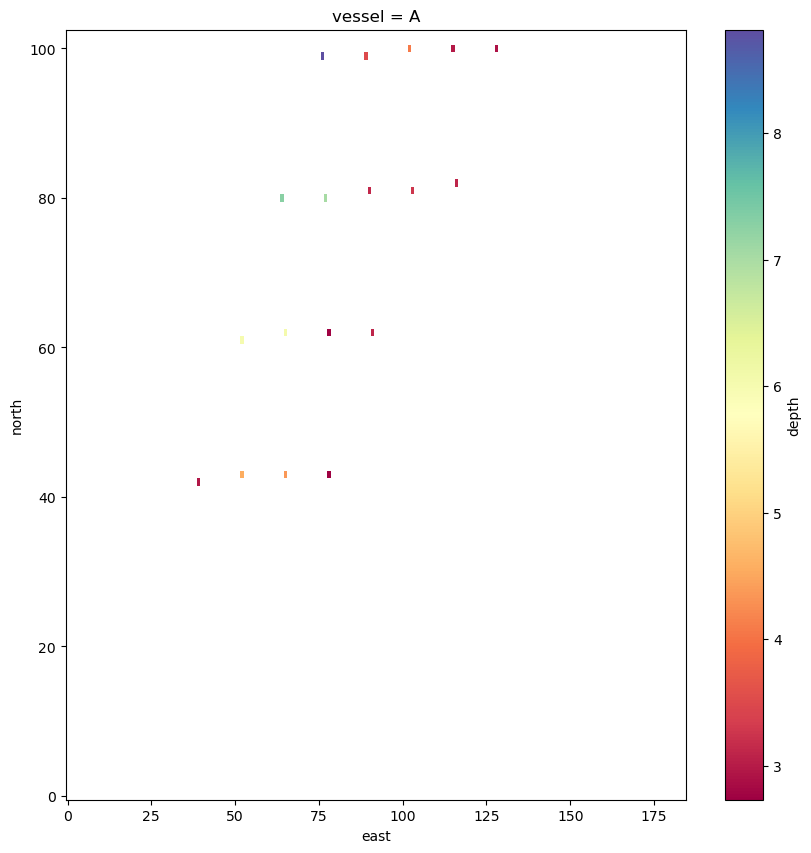

In [8]:
vA.depth.sel(vessel='A').plot(figsize=(10,10), cmap='Spectral')

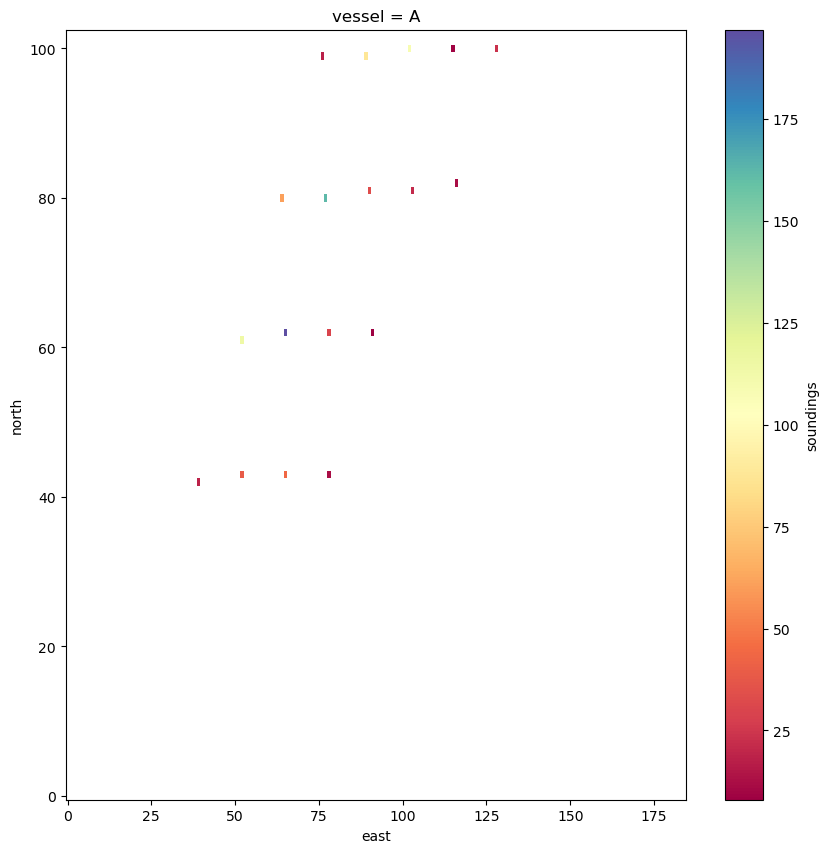

In [9]:
vA.soundings.sel(vessel='A').plot(figsize=(10,10), cmap='Spectral')

In [ ]:
vA.stdev.sel(vessel='A').plot(figsize=(10,10), cmap='Spectral')